In [14]:
import lime
from keras.applications import inception_v3 as inc_net
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image

In [11]:
model = inc_net.InceptionV3()

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 101s 1us/step


In [21]:
def transform_image(path_list):
    
    out = []
    for path in path_list:
        x = image.load_img(path, target_size = (299, 299))
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis = 0)
        x = preprocess_input(x)
        out.append(x)
        
        return np.vstack(out) 

In [27]:
img_path = ["elephant.jpg"]
preds= model.predict(transform_image(img_path))

In [29]:
from keras.applications.inception_v3 import decode_predictions

for x in decode_predictions(preds, 10)[0]:
    print(x)

('n01871265', 'tusker', 0.81208885)
('n02504458', 'African_elephant', 0.15029456)
('n02504013', 'Indian_elephant', 0.010993195)
('n03075370', 'combination_lock', 0.00031831846)
('n02391049', 'zebra', 0.00014530147)
('n03874599', 'padlock', 0.00014235893)
('n01855672', 'goose', 9.084976e-05)
('n01695060', 'Komodo_dragon', 8.8198154e-05)
('n03977966', 'police_van', 8.555766e-05)
('n02085936', 'Maltese_dog', 8.470842e-05)


In [33]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(transform_image(img_path)[0], model.predict,
                                         top_labels = 10,
                                         hide_color = 0,
                                        num_samples = 1000)

In [48]:
from keras.utils import get_file
import json

def get_index(name):
    
    name = name.lower()
    ind2items = get_file('imagenet_class_index.json',
                     'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json',
                      cache_subdir='models',
                      file_hash='c2c37ea517e94d9795004a39431a14cb')
    
    with open(ind2items, 'r') as file:
        index_dict = json.load(file)
        
      
    for key,value in index_dict.items():
        if index_dict[key][1].lower() == name:
            return int(key)
            
            
    return None
        

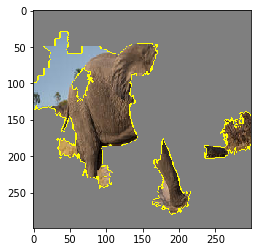

In [53]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

name = "Indian_elephant"
temp, mask = explanation.get_image_and_mask(get_index(name),
                                           positive_only = True,
                                           num_features = 10,
                                           hide_rest = True)

plt.imshow(mark_boundaries(temp /2 + 0.5, mask))
#plt.axis("off")
plt.show()

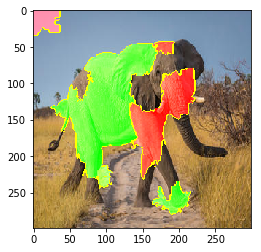

In [60]:
name = "Indian_elephant"
temp, mask = explanation.get_image_and_mask(get_index(name),
                                           positive_only = False,
                                           num_features = 10,
                                           hide_rest = False)

plt.imshow(mark_boundaries(temp/2 + 0.5, mask))
#plt.axis("off")
plt.show() # pros in green, cons in red

### LIME with Text

In [92]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

In [65]:
news_train = fetch_20newsgroups(subset = "train")
news_test = fetch_20newsgroups(subset = "test")

train_labels = news_train.target
train_data = news_train.data

test_labels = news_test.target
test_data = news_test.data

In [70]:
", ".join(news_train.target_names)

'alt.atheism, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x, misc.forsale, rec.autos, rec.motorcycles, rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, soc.religion.christian, talk.politics.guns, talk.politics.mideast, talk.politics.misc, talk.religion.misc'

In [85]:
class_names = news_train.target_names

In [96]:
class_names[0]

'alt.atheism'

In [106]:
# Classifying with Random Forest
vec = TfidfVectorizer()
clf = MultinomialNB(alpha = 0.01)

c = Pipeline([("vect", vec),
                    ("clf", clf)])

c.fit(train_data, train_labels)
preds = c.predict(test_data)

In [107]:
metrics.accuracy_score(test_labels, preds)

0.8352363250132767

In [125]:
instance = test_data[0]

In [126]:
instance

'From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. GANDLER)\nSubject: Need info on 88-89 Bonneville\nOrganization: University at Buffalo\nLines: 10\nNews-Software: VAX/VMS VNEWS 1.41\nNntp-Posting-Host: ubvmsd.cc.buffalo.edu\n\n\n I am a little confused on all of the models of the 88-89 bonnevilles.\nI have heard of the LE SE LSE SSE SSEI. Could someone tell me the\ndifferences are far as features or performance. I am also curious to\nknow what the book value is for prefereably the 89 model. And how much\nless than book value can you usually get them for. In other words how\nmuch are they in demand this time of year. I have heard that the mid-spring\nearly summer is the best time to buy.\n\n\t\t\tNeil Gandler\n'

In [130]:
c.predict_proba([instance])

array([[9.78227833e-04, 8.21631655e-03, 1.95769005e-03, 4.29654739e-02,
        3.63836639e-03, 2.44539140e-03, 1.75540736e-03, 5.71202157e-01,
        2.42536910e-02, 6.26143234e-03, 3.47282740e-02, 3.22394933e-04,
        2.77986533e-01, 3.00997850e-03, 7.67073279e-03, 9.93223803e-05,
        2.03102364e-03, 1.99420468e-04, 9.30212622e-04, 9.34795390e-03]])

In [134]:
from lime import lime_text
explainer = lime_text.LimeTextExplainer(class_names = class_names)
explanation = explainer.explain_instance(instance, 
                                        c.predict_proba,
                                        num_features = 7,
                                        labels = [1, 17])

TypeError: object of type 'NoneType' has no len()